# Problem 4.1

## Part a.

The box has 1000 cells, so there would be

$$
{1000 \choose 20} = \frac{1000!}{20! \times 980!}
$$

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from IPython.display import HTML
from tqdm.notebook import tqdm

In [12]:
scipy.special.comb(1000, 20)

3.394828113025067e+41

Assuming we colud check $10^{12}$ configurations per second, it would require $\sim 3 \times 10^{19}$ seconds, or about $10^{12}$ years to check every configuration.

## Part b.

In [218]:
class LennardJonesSimulation:
    
    def __init__(
        self, L: float = 10,
        r: float = 0.1,
        N: int = 20,
        LJ_eps: float = 0.1,
        ndims: int = 3
    ):
        self.L = L
        self.r = r
        self.N = N
        self.LJ_eps = LJ_eps
        self.ndims = ndims
        self.xs = np.random.uniform(low=0, high=L, size=(N, self.ndims))
        self.vs = np.zeros_like(self.xs)
    
    def _calc_r(self):
        rs = np.zeros((self.N, self.N, self.ndims))
        return self.xs[None, :] - self.xs[:, None]
    
    def _calc_f(self):
        r_vecs = self._calc_r()
        rs = np.linalg.norm(r_vecs, axis=2) + 1e-8
        forces = (
            -4 * self.LJ_eps * (
                12 * (self.r / rs)**11 - 6 * (self.r / rs)**5
            )[:, :, None] * (r_vecs / rs[:, :, None])
        )
        
        return np.sum(forces, axis=1)

    def update(self, dt: float = 0.001):
        forces = self._calc_f()
        self.xs += self.vs * dt
        self.vs += forces * dt
        
        # Handle collisions with the walls.
        out_of_box_idxs = np.argwhere(self.xs < 0)
        for i in out_of_box_idxs:
            self.xs[tuple(i)] *= -1
            self.vs[tuple(i)] *= -1
        
        out_of_box_idxs = np.argwhere(self.xs > self.L)
        for i in out_of_box_idxs:
            self.xs[tuple(i)] = 2 * self.L - self.xs[tuple(i)]
            self.vs[tuple(i)] *= -1
    
    def simulate(self, t: float = 100, dt: float = 0.001):
        for _ in range(int(t / dt)):
            self.update(dt)

In [170]:
def plot_momentum_hist(p, title):
    plt.hist(p, 20)
    plt.xlabel('$p_x$')
    plt.ylabel('$N$')
    plt.title(title)
    plt.show()

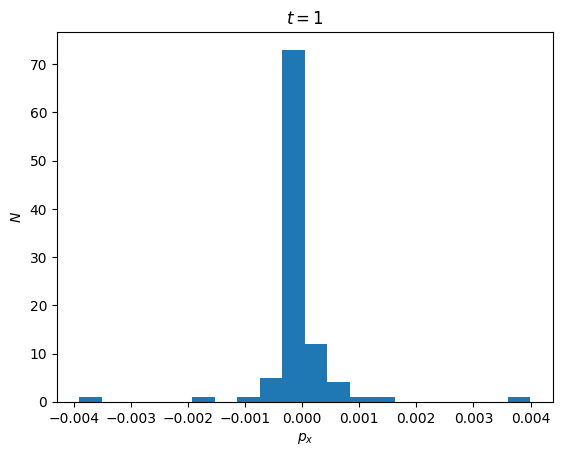

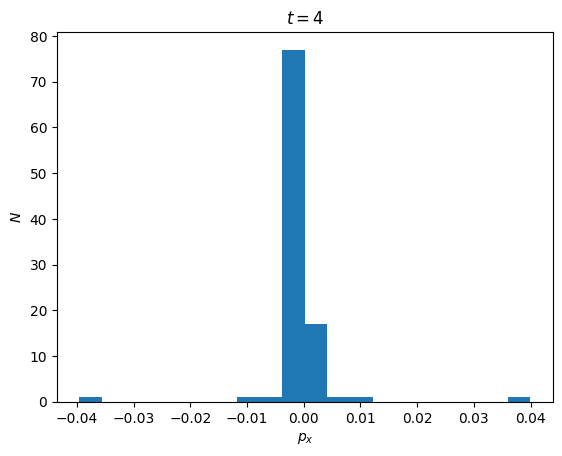

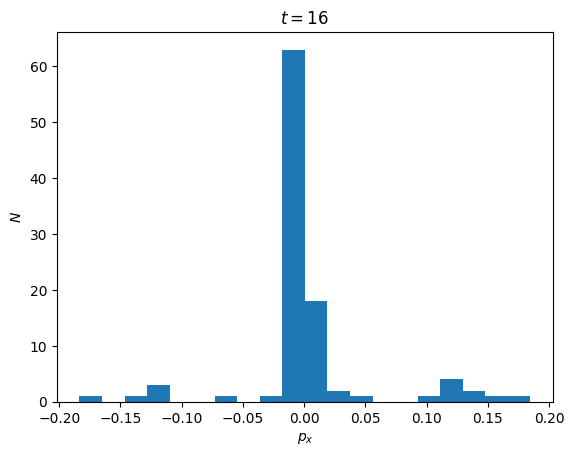

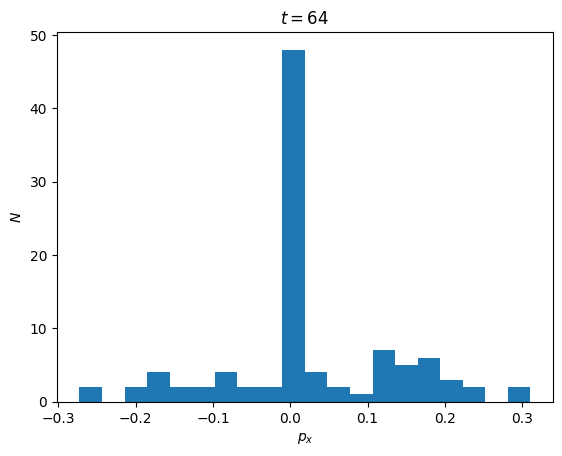

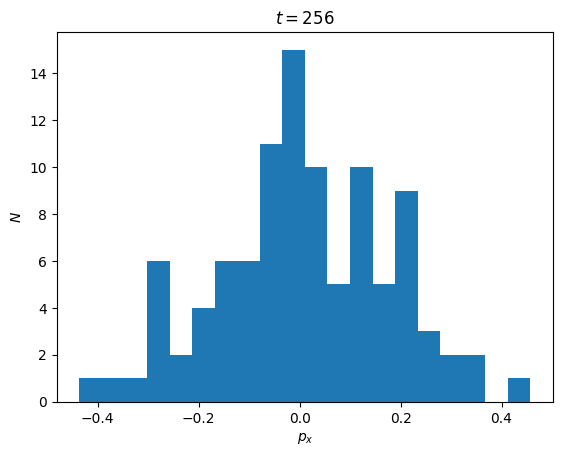

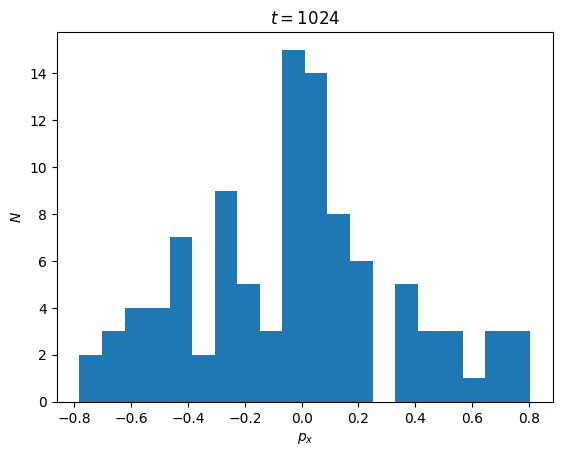

In [173]:
N = 100
simulation = LennardJonesSimulation(N=N, LJ_eps=1)

step = 1
for jump in range(6):
    simulation.simulate(3 * 4**(jump - 1))
    plot_momentum_hist(simulation.vs[:, 0], title=f'$t = {4**jump}$')

In [176]:
N = 100
simulation_2 = LennardJonesSimulation(N=N, LJ_eps=1)
for _ in tqdm(range(10)):
    simulation_2.simulate(1)

  0%|          | 0/10 [00:00<?, ?it/s]

To an order of magnitude, we would expect the equilibration time to be the time it takes a typical particle to interact with another particle (maybe times a few so that there are several interactions).  If the number density is $n$ and the cross section is $\sigma$, then the particles will have a mean free path of $\ell \sim \sigma / n$.  The time it takes to cross this path will be $t \sim \ell / v \sim \sigma / n v$.

In [231]:
from matplotlib.animation import FuncAnimation

N = 20
anim_simulation = LennardJonesSimulation(N=N, LJ_eps=1, ndims=2)

T = 2000
x_hist = np.zeros((T + 1, N, 2))
x_hist[0] = np.copy(anim_simulation.xs)
for i in tqdm(range(1, T + 1)):
    anim_simulation.simulate(0.1)
    x_hist[i] = np.copy(anim_simulation.xs)

  0%|          | 0/2000 [00:00<?, ?it/s]

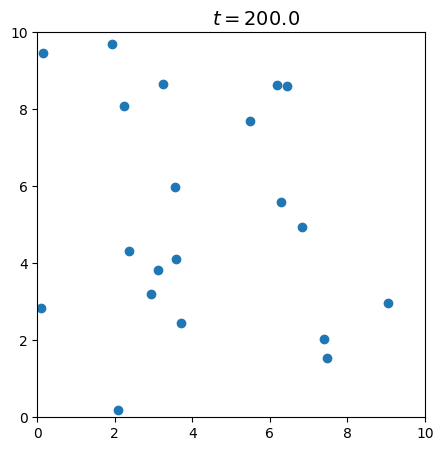

In [232]:
fig, ax = plt.subplots(figsize=(5, 5))
scat = ax.scatter([], [])
text = ax.text(4.5, 10.2, '', size=14)

def init():
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    return scat, text

def update_animation(frame):
    scat.set_offsets(x_hist[frame])
    text.set_text(f'$t = {frame / 10:0.1f}$')
    return scat, text
    
ani = FuncAnimation(
    fig=fig, func=update_animation, frames=range(T+1), interval=30, init_func=init
)
HTML(ani.to_html5_video())